In [1]:
### Basic cGAN for MNIST digit generation

In [2]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [3]:
# Define variables
CUDA = True
DATA_PATH = './data'
batch_size = 128
epochs = 150
lr = 2e-4
classes = 10
channels = 1
img_size = 64
latent_dim = 100
log_interval = 100

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
# CUDA = CUDA and torch.cuda.is_available()
# seed = 40
# print("PyTorch version: {}".format(torch.__version__))
# if CUDA:
#     print("CUDA version: {}\n".format(torch.version.cuda))

# if CUDA:
#     torch.cuda.manual_seed(seed)
# device = torch.device("cuda:1" if CUDA else "cpu")
# cudnn.benchmark = True

In [6]:
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(img_size),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [7]:
class Generator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Generator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)

        self.model = nn.Sequential(
            *self._create_layer(self.latent_dim + self.classes, 128, False),
            *self._create_layer(128, 256),
            *self._create_layer(256, 512),
            *self._create_layer(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def _create_layer(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, noise, labels):
        z = torch.cat((self.label_embedding(labels), noise), -1)
        x = self.model(z)
        x = x.view(x.size(0), *self.img_shape)
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self, classes, channels, img_size, latent_dim):
        super(Discriminator, self).__init__()
        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()

        self.model = nn.Sequential(
            *self._create_layer(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer(1024, 512, True, True),
            *self._create_layer(512, 256, True, True),
            *self._create_layer(256, 128, False, False),
            *self._create_layer(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, image, labels):
        x = torch.cat((image.view(image.size(0), -1), self.label_embedding(labels)), -1)
        return self.model(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

In [9]:
# Setup the generator and the discriminator
netG = Generator(classes, channels, img_size, latent_dim).to(device)
print(netG)
netD = Discriminator(classes, channels, img_size, latent_dim).to(device)
print(netD)

# Setup Adam optimizers for both G and D
optim_D = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optim_G = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

Generator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=4096, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (label_embedding): Embedding(10, 10)
  (adv_loss): BCELoss()
  (model): Sequential(
    (

In [11]:
# Train
img_list = []

netG.train()
netD.train()
viz_z = torch.zeros((batch_size, latent_dim), device=device)
viz_noise = torch.randn(batch_size, latent_dim, device=device)
nrows = batch_size // 8
viz_label = torch.LongTensor(np.array([num for _ in range(nrows) for num in range(8)])).to(device)

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        batch_size = data.size(0)
        real_label = torch.full((batch_size, 1), 1., device=device)
        fake_label = torch.full((batch_size, 1), 0., device=device)

        # Train G
        netG.zero_grad()
        z_noise = torch.randn(batch_size, latent_dim, device=device)
        x_fake_labels = torch.randint(0, classes, (batch_size,), device=device)
        x_fake = netG(z_noise, x_fake_labels)
        y_fake_g = netD(x_fake, x_fake_labels)
        g_loss = netD.loss(y_fake_g, real_label)
        g_loss.backward()
        optim_G.step()

        # Train D
        netD.zero_grad()
        y_real = netD(data, target)
        d_real_loss = netD.loss(y_real, real_label)
        y_fake_d = netD(x_fake.detach(), x_fake_labels)
        d_fake_loss = netD.loss(y_fake_d, fake_label)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optim_D.step()
        
        if batch_idx % log_interval == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f}'.format(
                        epoch, batch_idx, len(dataloader),
                        d_loss.mean().item(),
                        g_loss.mean().item()))
            
            with torch.no_grad():
                viz_sample = netG(viz_noise, viz_label)
                img_list.append(vutils.make_grid(viz_sample, normalize=True))
    torch.save({
        'epoch': epoch,
        'model_state_dict': netG.state_dict(),
        'optimizer_state_dict': optim_G.state_dict(),
        'loss_D':d_loss,
        'loss_G':g_loss,
        
    }, 'cGAN_originalMNIST.pth')
    
print("Training completed!")

Epoch 0 [100/469] loss_D: 0.6398 loss_G: 1.8145
Epoch 0 [200/469] loss_D: 0.5602 loss_G: 1.1315
Epoch 0 [300/469] loss_D: 0.5945 loss_G: 0.7790
Epoch 0 [400/469] loss_D: 0.5404 loss_G: 1.3696
Epoch 1 [100/469] loss_D: 0.6554 loss_G: 0.5217
Epoch 1 [200/469] loss_D: 0.6488 loss_G: 0.5388
Epoch 1 [300/469] loss_D: 0.6709 loss_G: 0.5536
Epoch 1 [400/469] loss_D: 0.7989 loss_G: 0.3033
Epoch 2 [100/469] loss_D: 0.4413 loss_G: 1.6084
Epoch 2 [200/469] loss_D: 0.4312 loss_G: 2.2363
Epoch 2 [300/469] loss_D: 0.8174 loss_G: 0.2922
Epoch 2 [400/469] loss_D: 0.5660 loss_G: 0.9783
Epoch 3 [100/469] loss_D: 0.6009 loss_G: 0.8662
Epoch 3 [200/469] loss_D: 0.4410 loss_G: 1.4543
Epoch 3 [300/469] loss_D: 0.5390 loss_G: 0.7130
Epoch 3 [400/469] loss_D: 0.4544 loss_G: 0.9181
Epoch 4 [100/469] loss_D: 0.5652 loss_G: 1.4493
Epoch 4 [200/469] loss_D: 0.5385 loss_G: 0.9219
Epoch 4 [300/469] loss_D: 0.6373 loss_G: 0.8144
Epoch 4 [400/469] loss_D: 0.6205 loss_G: 0.5499
Epoch 5 [100/469] loss_D: 0.4876 loss_G:

# Plot fake images

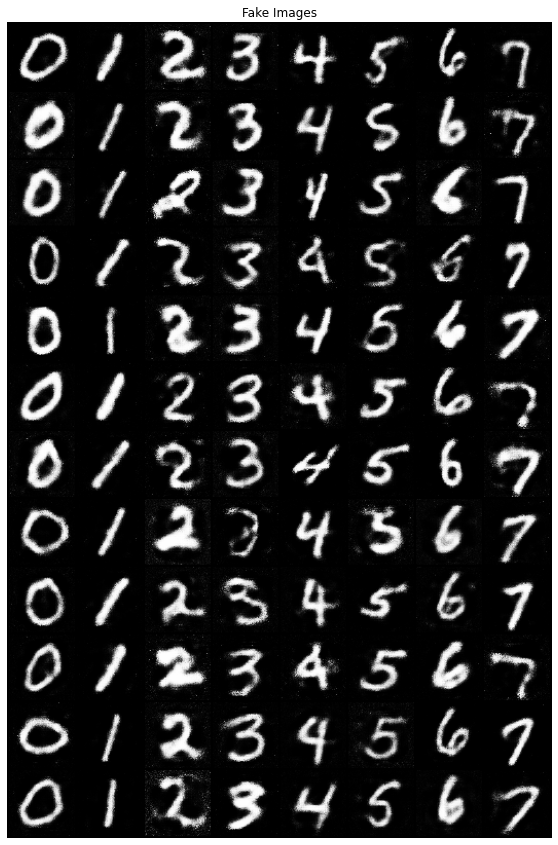

In [13]:
# Plot the fake images
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
plt.show()

In [14]:
def generate_fake_images_with_label(generator, label, num_images):
    generator.eval()  # Set the generator to evaluation mode
    noise = torch.randn(num_images, latent_dim, device=device)  # Generate random noise
    labels = torch.full((num_images,), label, device=device, dtype=torch.long)  # Create labels tensor

    with torch.no_grad():
        generated_images = generator(noise, labels)  # Generate fake images with specific label

    generator.train()  # Set the generator back to training mode

    return generated_images


In [19]:
fake_images = generate_fake_images_with_label(netG, 8, 10)

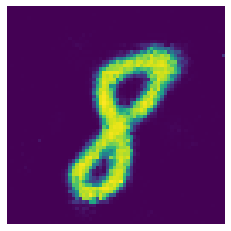

In [20]:
plt.imshow(fake_images[0].cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fake_images(fake_images):
    fake_images = fake_images.cpu()  # Move the tensor to CPU if necessary
    fake_images = 0.5 * (fake_images + 1)  # Denormalize the images
    fake_images = fake_images.detach().numpy()  # Convert the tensor to a NumPy array
    fake_images = np.transpose(fake_images, (0, 2, 3, 1))  # Reshape the array for plotting

    num_images = fake_images.shape[0]
    nrows = int(np.sqrt(num_images))
    ncols = int(np.ceil(num_images / nrows))

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(fake_images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()


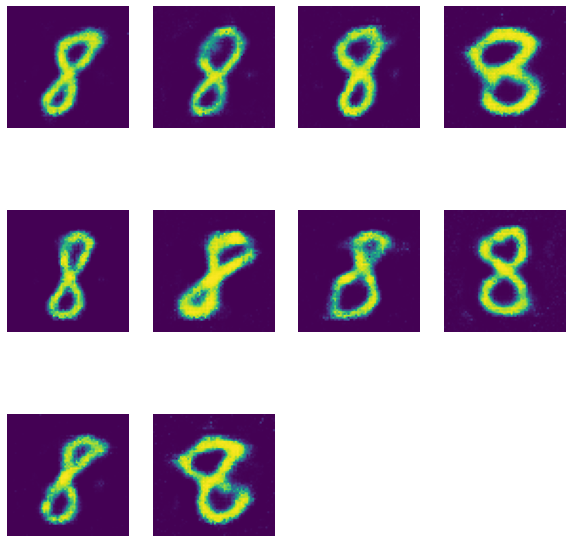

In [22]:
plot_fake_images(fake_images)